##### Copyright 2020 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# TensorFlow Lite の超解像技術

<table class="tfo-notebook-buttons" align="left">
  <td>     <a target="_blank" href="https://www.tensorflow.org/lite/examples/super_resolution/overview">     <img src="https://www.tensorflow.org/images/tf_logo_32px.png">     TensorFlow.org で表示</a>
</td>
  <td>     <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/ja/lite/models/super_resolution/overview.ipynb">     <img src="https://www.tensorflow.org/images/colab_logo_32px.png">     Google Colab で実行</a>
</td>
  <td><a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/ja/lite/models/super_resolution/overview.ipynb">     <img src="https://www.tensorflow.org/images/GitHub-Mark-32px.png">     GitHubでソースを表示</a></td>
  <td><a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/ja/lite/models/super_resolution/overview.ipynb"><img src="https://www.tensorflow.org/images/download_logo_32px.png">ノートブックをダウンロード</a></td>
  <td>     <a href="https://tfhub.dev/captain-pool/esrgan-tf2/1"><img src="https://www.tensorflow.org/images/hub_logo_32px.png">TF Hub モデルを参照</a>
</td>
</table>

## 概要

一般的に、低解像度の画像から高解像度 (HR) の画像を回復する作業は、Single Image Super Resolution (SISR) と呼ばれます。

ここで使用されるモデルは ESRGAN ([ESRGAN: Enhanced Super-Resolution Generative Adversarial Networks](https://arxiv.org/abs/1809.00219)) です。TensorFlow Lite を使用して、あらかじめトレーニングされたモデルで推論を実行します。

TFLite モデルは、TF ハブでホスティングされているこの[実装](https://tfhub.dev/captain-pool/esrgan-tf2/1)から変換されます。変換されたモデルは、50 x 50 の低解像度画像を 200 x 200 (倍率 4 倍) の高解像度画像にアップサンプリングします。別の入力サイズまたは倍率を使用する場合は、元のモデルを再変換するか、再トレーニングする必要があります。

## MNIST モデルをビルドする

まず、必要なライブラリをインストールします。

In [2]:
!pip install matplotlib tensorflow tensorflow-hub

依存関係をインポートします。

In [3]:
import tensorflow as tf
import tensorflow_hub as hub
import matplotlib.pyplot as plt
print(tf.__version__)

2024-01-11 17:49:54.063947: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-01-11 17:49:54.063990: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-01-11 17:49:54.065444: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


2.15.0


ESRGAN モデルをダウンロードして変換します。

In [4]:
model = hub.load("https://tfhub.dev/captain-pool/esrgan-tf2/1")
concrete_func = model.signatures[tf.saved_model.DEFAULT_SERVING_SIGNATURE_DEF_KEY]

@tf.function(input_signature=[tf.TensorSpec(shape=[1, 50, 50, 3], dtype=tf.float32)])
def f(input):
  return concrete_func(input);

converter = tf.lite.TFLiteConverter.from_concrete_functions([f.get_concrete_function()], model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

# Save the TF Lite model.
with tf.io.gfile.GFile('ESRGAN.tflite', 'wb') as f:
  f.write(tflite_model)

esrgan_model_path = './ESRGAN.tflite'

INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpo82w2j1z/assets


INFO:tensorflow:Assets written to: /tmpfs/tmp/tmpo82w2j1z/assets


2024-01-11 17:50:16.024291: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:378] Ignored output_format.
2024-01-11 17:50:16.024331: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:381] Ignored drop_control_dependency.
Summary on the non-converted ops:
---------------------------------
 * Accepted dialects: tfl, builtin, func
 * Non-Converted Ops: 176, Total Ops 845, % non-converted = 20.83 %
 * 176 ARITH ops

- arith.constant:  176 occurrences  (f32: 174, i32: 2)



  (f32: 45)
  (f32: 132)
  (f32: 169)
  (f32: 2)
  (f32: 136)
  (f32: 11)
  (uq_8: 169)
  (f32: 2)


テスト画像 (昆虫の頭) をダウンロードします。

In [5]:
test_img_path = tf.keras.utils.get_file('lr.jpg', 'https://raw.githubusercontent.com/tensorflow/examples/master/lite/examples/super_resolution/android/app/src/main/assets/lr-1.jpg')

6432/6432 [==============================] - 0s 0us/step


## TensorFlow Lite で超解像度画像を生成する

In [6]:
lr = tf.io.read_file(test_img_path)
lr = tf.image.decode_jpeg(lr)
lr = tf.expand_dims(lr, axis=0)
lr = tf.cast(lr, tf.float32)

# Load TFLite model and allocate tensors.
interpreter = tf.lite.Interpreter(model_path=esrgan_model_path)
interpreter.allocate_tensors()

# Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Run the model
interpreter.set_tensor(input_details[0]['index'], lr)
interpreter.invoke()

# Extract the output and postprocess it
output_data = interpreter.get_tensor(output_details[0]['index'])
sr = tf.squeeze(output_data, axis=0)
sr = tf.clip_by_value(sr, 0, 255)
sr = tf.round(sr)
sr = tf.cast(sr, tf.uint8)

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


## 結果を視覚化する

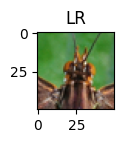

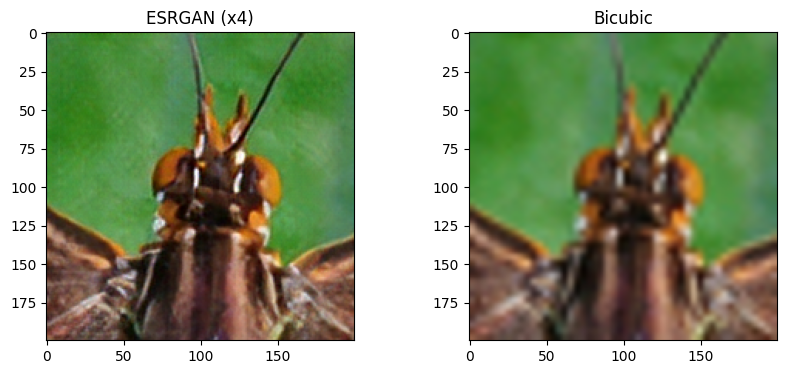

In [7]:
lr = tf.cast(tf.squeeze(lr, axis=0), tf.uint8)
plt.figure(figsize = (1, 1))
plt.title('LR')
plt.imshow(lr.numpy());

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)        
plt.title(f'ESRGAN (x4)')
plt.imshow(sr.numpy());

bicubic = tf.image.resize(lr, [200, 200], tf.image.ResizeMethod.BICUBIC)
bicubic = tf.cast(bicubic, tf.uint8)
plt.subplot(1, 2, 2)   
plt.title('Bicubic')
plt.imshow(bicubic.numpy());

## パフォーマンスベンチマーク

パフォーマンスベンチマークの数値は、[ここで説明する](https://www.tensorflow.org/lite/performance/benchmarks)ツールで生成されます。

<table>
  <thead>
    <tr>
      <th>モデル名</th>
      <th>モデルサイズ</th>
      <th>デバイス</th>
      <th>CPU</th>
      <th>GPU</th>
    </tr>
  </thead>
  <tr>
    <td rowspan="3">       super resolution (ESRGAN)</td>
    <td rowspan="3">       4.8 Mb</td>
    <td>Pixel 3</td>
    <td>586.8ms*</td>
      <td>128.6ms</td>
  </tr>
  <tr>
     <td>Pixel 4</td>
    <td>385.1ms*</td>
      <td>130.3ms</td>
  </tr>
</table>

**{nbsp}4 スレッド使用*